## An Introduction to JuMP for Algebraic Modeling


_by Dharik S. Mallapragada (last updated: August 4, 2025)_

This notebook will provide a basic introduction to [algebraic modeling](https://en.wikipedia.org/wiki/Algebraic_modeling_language) for [constrained optimization](https://en.wikipedia.org/wiki/Constrained_optimization) problems using the [Julia](https://julialang.org/) language and [JuMP](http://jump.dev/). The notebook will walk through the main components of an optimization model (decision variables, constraints, expressions, sets, objective function), show how to interface with a solver to find solutions to the model, and how to read solutions outputs back into Julia [DataFrames](https://juliadata.github.io/DataFrames.jl/stable/) and/or [write outputs to .csv files](https://juliadata.github.io/CSV.jl/stable/) for post-processing.

For additional resources, see the collection of notebooks provided at [JuMPTutorials.jl](https://github.com/jump-dev/JuMPTutorials.jl).

 The material below is adapted from the material prepared by Michael Davidson and Jesse D. Jenkins for a course on power systems optimization available [here](https://github.com/Power-Systems-Optimization-Course/power-systems-optimization)

<img src="img/jump_logo.png" style="width: 450px; height: auto" align="left">

### What is JuMP?

[JuMP](http://jump.dev/) ("Julia for Mathematical Programming") is an open-source modeling language and supporting packages for mathematical optimization/algebraic programming in the [Julia](https://julialang.org/) high performance scientific programming language. 

JuMP makes it easy to formulate and solve linear programming, semidefinite programming, integer programming, convex optimization, constrained nonlinear optimization, and related classes of optimization problems, using easy-to-read code with syntax that closely matches the mathematical formulation of optimization problems. 

These problems can then be solved via a variety of open source or commercial optimization solvers, using Julia packages for interfacing with each solver. Thus, the definition of an algebraic model for a constrained optimization problem in JuMP is independent of the choice of solver. 

In this way, JuMP is similar to [AMPL](https://en.wikipedia.org/wiki/AMPL), [AIIMS](https://en.wikipedia.org/wiki/AIMMS) or [GAMS](https://en.wikipedia.org/wiki/General_Algebraic_Modeling_System) -- all specialized languages built for algebraic modeling. However, JuMP offers the advantage of being embeded within a fully functioning, high-level programming language (Julia). In this way, it is similar to the [Pyomo](http://www.pyomo.org/) package for Python. (For a brief [comparison between Julia and Python](https://devathon.com/blog/julia-vs-python-which-programming-language-is-better/), see here).

### Installing JuMP and other Julia packages

We will need to install JuMP (Julia for Mathematical Programming), which is a  package for setting up optimization models in Julia. 
In addition to JuMP, we need to install package that interfaces with a linear programming solver. There are many such solvers:
- [Gurobi](https://www.gurobi.com/academia/academic-program-and-licenses/ ) - needs a license (academic license available)
- [CPLEX](https://academic.ibm.com/a2mt/downloads/data_science?cardID=52 ) - needs a license (academic license available)
- [HiGHS](https://highs.dev/ ) - no license needed
For each solver, we will need to install the corresponding package that interfaces between the JuMP and the solver. In effect, JuMP prepares the mathametical model object that sent to the solver which subsequently returns the solution and this communication is managed via the package. As we will only use HiGHs for this example, we will install [HGHS.jl](https://github.com/jump-dev/HiGHS.jl), the interface for the open source [HiGHS solver](https://highs.dev/) for linear optimization (LP and MILP problems).

For projects and class assignments, students are strongly encouraged to use Gurobi whose setup for JuMP can be found [here](https://jump.dev/JuMP.jl/stable/packages/Gurobi/) 

## Installation process
We have included HiGHs and JuMP as part of the project environment, so you should be able to install them along with other packages by activating the package.


Troubleshooting Julia installations  -JuMP is installed by using the built-in package manager.[See this guide to installing and setting up Julia and JuMP](http://bit.ly/JuliaSetupGuide) for any troubleshooting steps

In [2]:
# Before you use a package in Julia for the first time, you must "add" (install) it. 
# We have included a project file that specifies the packages we need.
# You can install the packages specified in the project file by following these commands
# Make sure you have set the kernel to Julia in your Jupyter notebook
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `c:\Users\dm6004\MIT Dropbox\Dharik Mallapragada\NYU_teaching\EnergySystems_course\Codes\optimization_intro`


In [3]:
# Load JuMP and HiGHS packages for use in this notebook as well as Plots for visualization
using JuMP
using HiGHS
using Plots


## A factory example

Let's start by recalling our simple factory optimization example from the [Constrained Optimization notebook](Notebooks/Constrained-Optimization.ipynb), which seeks to maximize total revenue as a function of how many widgets of type A (decision variable $x$) and type B (decision variable $y$) to produce:


\begin{align}
& \max 150 x + 175 y &\text{Objective function (revenue)}\\ 
& \text{s.t.} & \\
& 10 x + 8 y \leq \ 80 &\text{Time constraint}\\
& 7 x + 11 y \leq \ 77 &\text{Materials constraint}\\
& x \leq 8 &\text{Capacity constraint}\\
& x, y \geq 0 &\text{Non-negativity constraints}\\
\end{align}


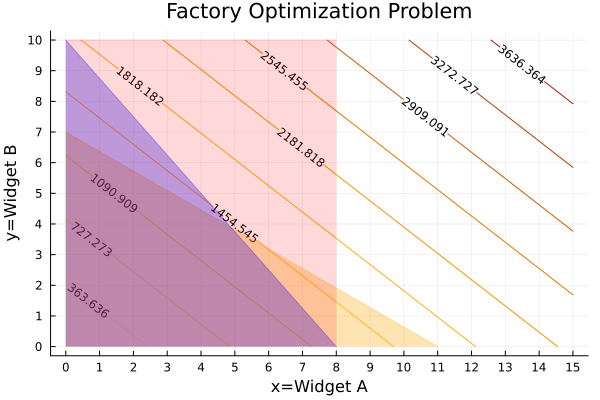

In [5]:
# set up parameters and variables
pa = 150
pb = 175
a = range(0,15,step=0.5)
b = range(0,10,step=0.5)

# define objective function
f(a, b) = begin  (pa*a + pb*b)  end 

contour(a,b,(a,b)->f(a,b),nlevels=10, c=:heat, linewidth=1, colorbar = false, contour_labels = true)
title!("Factory Optimization Problem")
xaxis!("x=Widget A")
yaxis!("y=Widget B")
xticks!(0:maximum(a))
yticks!(0:maximum(b))
areaplot!(a[a.<=11], (77 .- 7*a[a.<=11])./11, legend=false, opacity=0.3, color=:orange)
areaplot!(a[a.<=8], (80 .- 10*a[a.<=8])./8, legend=false, opacity=0.3, color=:blue)
areaplot!(a[a.<=8], repeat([maximum(b)],length(a[a.<=8])), legend=false, opacity=0.15, color=:red)


JuMP allows us to define an algebraic model that represents this optimization problem, which we'll do in several steps now...

### 1. Define the model

First, we **define the model**. A JuMP model object is a container for variables, constraints, solver options, etc. Models are created with the [Model()](https://jump.dev/JuMP.jl/stable/solvers/#JuMP.Model-Tuple{}) function. 

In [6]:
factory_model = Model();

### 2. Specify the optimization solver

To solve a model, we need to also specify the [optimization solver](https://jump.dev/JuMP.jl/stable/solvers/#) (or "optimizer") for JuMP to use. 

A solver is a software package that incorporates computationally efficient algorithms for finding solutions to one or more classes of optimization problems -- e.g. [simplex](https://en.wikipedia.org/wiki/Simplex_algorithm) and [interior-point](https://en.wikipedia.org/wiki/Interior-point_method) algorithms for solving linear programming (LP) problems; [branch-and-bound](https://en.wikipedia.org/wiki/Branch_and_bound) and [branch-and-cut](https://en.wikipedia.org/wiki/Branch_and_cut) algorithms for solving mixed-integer linear programming (MILP) problems.

JuMP currently supports a number of open-source and commercial solvers which can be viewed
[here](https://jump.dev/JuMP.jl/stable/installation/#Supported-solvers).

We specify the specific solver to use for this model either by using the [set_optimizer()](https://jump.dev/JuMP.jl/stable/solvers/#JuMP.set_optimizer) function or as an argument for the [Model()](https://jump.dev/JuMP.jl/stable/solvers/#JuMP.Model-Tuple{}) function when initially defining the model, as in the following examples...

In [10]:
set_optimizer(factory_model, HiGHS.Optimizer)
factory_model = Model(HiGHS.Optimizer);

Above, we specify the HiGHS solver interface. The argument `HiGHS.Optimizer` is an example of a JuMP "Optimizer Factory" parameter, a call to create an interface with a specific solver. Other examples include `GLPK.Optimizer`, `Clp.Optimizer`, `CPLEX.Optimizer`, `Gurobi.Optimizer`, etc.

### 3. Define variables

Next, we define our [decision variables](https://jump.dev/JuMP.jl/stable/variables/), using the JuMP [@variable](https://jump.dev/JuMP.jl/stable/variables/#JuMP.@variable) [macro](https://docs.julialang.org/en/v1/manual/metaprogramming/#man-macros). 

The first argument in the `@variable()` macro is a reference to the model object that this decision variable is associated with, in this case `factory_model`. 

We can also pass lower and/or upper bounds on the decision variables at the time they are created using `<=` and `>=` notation...

In [8]:
@variable(factory_model, 8 >= x >= 0) # How many widgets of type A, including capacity constraint as upper bound

x

In [9]:
@variable(factory_model, y >= 0) # How many widgets of type B

y

...Here we set a lower bound of 0 for both variables (e.g. ```y >= 0```), to reflect the non-negativity constraints in our decision variables (e.g. that we cannot produce a negative amount of widgets), and an upper bound of 8 for variable $x$, to reflect the capacity constraint on production of widget A (```8 >= x >=0```).

You can also specify bounds by using the `lower_bound` and `upper_bound` keyword arguments (as in `@variable(model, x, lower_bound = 0, upper_bound = 8`). 

A variable without bounds is considered a "free variable" and is defined by simply ommitting any bounds (as in `@variable(model, free_x)`).

The name provided for the variable in the `@variable` macro is the "[base name](https://jump.dev/JuMP.jl/stable/variables/#Variable-names-1)" assigned to this variable (e.g. `x` and `y` for our variables above). 

You can use the variable's base name as an argument in other JuMP functions to query attributes of this variable (or to recover a variable's value after solving the model). For example, we can check the upper bound on the `x` variable as follows...

In [13]:
upper_bound(x)

8.0

Note that JuMP requires unique names for variables, expressions, and constraints. If you try to define the same variable name more than once, JuMP will throw an error to prevent you from accidentally overwriting the same variable (or constraint or expression). 

In [14]:
@variable(factory_model, x >= 0) # Try defining x for a second time with different bounds

LoadError: An object of name x is already attached to this model. If this
    is intended, consider using the anonymous construction syntax, e.g.,
    `x = @variable(model, [1:N], ...)` where the name of the object does
    not appear inside the macro.

    Alternatively, use `unregister(model, :x)` to first unregister
    the existing name from the model. Note that this will not delete the
    object; it will just remove the reference at `model[:x]`.


You can see that the $x$ variable still has the old upper bound and has not been modified by the above attempt to define it again. 

In [10]:
upper_bound(x)

8.0

If we'd really wanted to modify the bounds for an existing JuMP variable, we would use the the `set_lower_bound` and `set_upper_bound` functions, or the ` delete_lower_bound` and `delete_upper_bound` functions to remove a previously established bound.

You can check if a name has already been assigned to a valid JuMP object (variable, expression, constraint) with the `is_valid(model_reference, JuMP_base_name)` function, and [delete an existing JuMP object](https://jump.dev/JuMP.jl/dev/variables/#Deleting-variables-1) with the `delete(model_reference, JuMP_base_name)` function.

In [16]:
is_valid(factory_model, x)

true

You can also use JuMP's `all_variables(model_reference)` function to enumerate a vector of references to all defined JuMP variables (although be careful doing this for very large models!)

In [11]:
all_variables(factory_model)

2-element Vector{VariableRef}:
 x
 y

### 4. Define constraints

Next, we can define our more complicated constraints, which involve multiple variables.

We have two constraints to define in this simple example, our time constraint, $10 x + 8 y \leq \ 80$ and our material constraint, $7 x + 11 y \leq \ 77$.

We define constraints with the JuMP [@constraint](https://jump.dev/JuMP.jl/stable/constraints/#The-@constraint-macro-1) macro.

In [12]:
@constraint(factory_model, time_constraint, 10x + 8y <= 80) # Time constraint

time_constraint : 10 x + 8 y <= 80

In [13]:
@constraint(factory_model, materials_constraint, 7x + 11y <= 77) # Materials constraint

materials_constraint : 7 x + 11 y <= 77

We can now call the model object we've been building, and JuMP will helpfully print out the mathematical formulation

In [14]:
print(factory_model)

Feasibility
Subject to
 time_constraint : 10 x + 8 y <= 80
 materials_constraint : 7 x + 11 y <= 77
 x >= 0
 y >= 0
 x <= 8


As you can see, we've now defined all of the constraints in our simple factory model. But we're missing one very important thing...

### 5. Define objective function

Currently, our model only defines a feasible region (e.g. a set of constraints over the domain of our defined decision variables). But we have not specified what our objective function is: what are we trying to maximize or minimize?

To define our objective function, we use the [@objective](https://jump.dev/JuMP.jl/dev/objective/#JuMP.@objective) macro. We have three arguments for this macro: (1) the model object we are defining the objective for, (2) specify whether this is a maximization (`Max`) or minimization (`Min`) problem, and (3) define the objective function itself.

In [15]:
@objective(factory_model, Max, 150x + 175y)

150 x + 175 y

Now we can see the full model is defined...

In [17]:
print(factory_model)

Max 150 x + 175 y
Subject to
 time_constraint : 10 x + 8 y <= 80
 materials_constraint : 7 x + 11 y <= 77
 x >= 0
 y >= 0
 x <= 8


### 6. Alternative ways to define our model

We can define more than one variable at a time using a more compact syntax by using the [@variables](https://jump.dev/JuMP.jl/stable/variables/#variables-1) macro. Here we'll define both x and y variables at the same time...

In [18]:
factory_model = Model(HiGHS.Optimizer);
@variables(factory_model, begin
    8 >= x >= 0
    y >= 0
    end)
print(factory_model)

Feasibility
Subject to
 x >= 0
 y >= 0
 x <= 8


Note that the @variables macro does not automatically print the variable bounds, so we use the `print(model_name)` function above to print out the newly defined variables and their bounds.

We can also use the [@constraints](https://jump.dev/JuMP.jl/stable/constraints/#The-@constraints-macro-1) macro in a similar manner to define multiple constraints in a more compact syntax, if preferred...

In [19]:
@constraints(factory_model, begin
    time_constraint, 10x + 8y <= 80
    materials_constraint, 7x + 11y <= 77    
    end)
print(factory_model)

Feasibility
Subject to
 time_constraint : 10 x + 8 y <= 80
 materials_constraint : 7 x + 11 y <= 77
 x >= 0
 y >= 0
 x <= 8


Sometimes it is useful to define an algebraic [expression](https://jump.dev/JuMP.jl/stable/expressions/#) that may be inserted into constraints, objective functions, or other expressions (e.g. to build up more complex expressions or to define an expression used repeatedly in multiple constraints). Defining an expression can also be useful if you want to query the value of a particular expression after solving the model. 

The recommended way to create an expression is via the [@expression](https://jump.dev/JuMP.jl/stable/expressions/#JuMP.@expression) macro, which is syntactically similar to the definition of a constraint. The difference is that an expression is not directly part of the optimization problem definition. It only becomes incorporated into the model definition if you subsequently use a defined expression to define part of a constraint or objective function. As an example, let's use an expression here to define our objective function...

In [20]:
@expression(factory_model, objective, 150x + 175y)
@objective(factory_model, Max, objective)
print(factory_model)

Max 150 x + 175 y
Subject to
 time_constraint : 10 x + 8 y <= 80
 materials_constraint : 7 x + 11 y <= 77
 x >= 0
 y >= 0
 x <= 8


### 7. Solve the model

Now that we've defined our factory model, let's solve it to find the optimal values $(x^*, y^*)$ that maximizes our objective function. 

To optimize a defined JuMP model for which a solver has been previously specified, use the [optimize!](https://jump.dev/JuMP.jl/stable/solvers/#JuMP.optimize!) function, supplying the model name as an argument...

In [21]:
optimize!(factory_model)

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
LP   has 2 rows; 2 cols; 4 nonzeros
Coefficient ranges:
  Matrix [7e+00, 1e+01]
  Cost   [2e+02, 2e+02]
  Bound  [8e+00, 8e+00]
  RHS    [8e+01, 8e+01]
Presolving model
2 rows, 2 cols, 4 nonzeros  0s
2 rows, 2 cols, 4 nonzeros  0s
Presolve : Reductions: rows 2(-0); columns 2(-0); elements 4(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -2.1874652580e+01 Ph1: 2(2.375); Du: 1(21.8747) 0s
          2     1.4138888889e+03 Pr: 0(0) 0s
Model status        : Optimal
Simplex   iterations: 2
Objective value     :  1.4138888889e+03
P-D objective error :  0.0000000000e+00
HiGHS run time      :          0.00


We see that the solver (HiGHS) solved our optimization problem and found the optimal objective function value of 1413.888889. 

### 8. Query the optimal solution

But what are the optimal decision variable values $(x^*, y^*)$? Now that the model has been solved to optimality, we can query the values of JuMP variables by using JuMP's [value()](https://jump.dev/JuMP.jl/stable/solutions/#JuMP.value) function

In [ ]:
value(x)


4.888888888888888

In [22]:
value(y)

3.888888888888889

Quick note: because JuMP uses [different containers](https://jump.dev/JuMP.jl/dev/containers/) depending on whether we've defined a single variable, a vector or square array of variables, or an array of variables with differing dimension lengths, they [recommend](https://jump.dev/JuMP.jl/dev/solutions/#Obtaining-solutions-1) using the [vectorized syntax or "dot syntax"](https://docs.julialang.org/en/v1/manual/functions/#man-vectorized) for the `value()` function, `value.(ref)`, rather than the `value(ref)` syntax used above. 

The `value.(ref)` syntax will work with any vector or array of variables and also with single variables (which can be treated as a vector of length 1), while the `value(ref)` syntax will only work when called for single variables. In this case, since we have a single variable only, we can use either syntax. We'll see an example of a vector of variables in the next section of this notebook...

In [23]:
value.(x)

4.888888888888888

In [24]:
value.(y)

3.888888888888889

We can now see the optimal solution to our simple factory optimization model is $(x^*, y^*) = (4.8889, 3.8889)$, just as we determined in the [Constrained Optimization notebook](01-Constrained-Optimization.ipynb) via linear algebra.

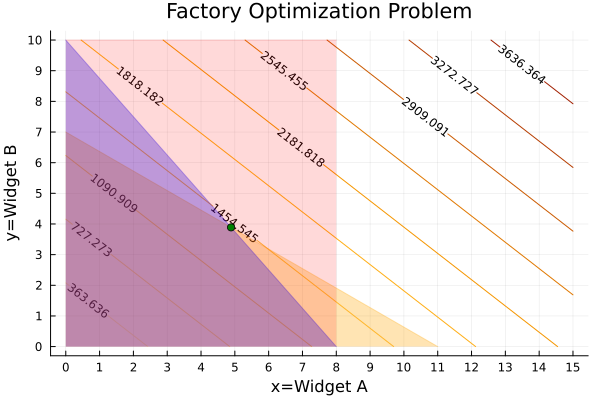

In [27]:
contour(a,b,(a,b)->f(a,b),nlevels=10, c=:heat, linewidth=1, colorbar = false, contour_labels = true)
title!("Factory Optimization Problem")
xaxis!("x=Widget A")
yaxis!("y=Widget B")
xticks!(0:maximum(a))
yticks!(0:maximum(b))
areaplot!(a[a.<=11], (77 .- 7*a[a.<=11])./11, legend=false, opacity=0.3, color=:orange)
areaplot!(a[a.<=8], (80 .- 10*a[a.<=8])./8, legend=false, opacity=0.3, color=:blue)
areaplot!(a[a.<=8], repeat([maximum(b)],length(a[a.<=8])), legend=false, opacity=0.15, color=:red)
scatter!([value.(x)],[value.(y)], markercolor="green")

We can also use the `value()` function to evaluate the value of named expressions and constraints we've previously defined and associated with the solved model. (Again, vectorized dot syntax is recommended, but both forms work for single constraints).

In [32]:
value.(time_constraint)

80.0

We can see that this is the same value as we'd get by evaluating the time constraint at the optimal values $(x^*, y^*)$

In [33]:
10*value.(x) + 8*value.(y)

80.0

We can also evaluate the `objective` expression we defined previously, $150x + 175y$, and save this to a variable names `optimal_revenue` (e.g. for use later).

In [34]:
optimal_revenue = value(objective)

1413.8888888888887

Or we can directly query the objective function value associated with our `factory_model` JuMP model object by using JuMP's `objective_value()` function and passing a reference to the model as follows. Since we don't always define an expression for our objective function, this is the typical way to access the objective function value for our optimal solution.

In [35]:
optimal_revenue = objective_value(factory_model)

1413.8888888888887

Note that if there are certain expressions that you want to be able to quickly extract from the model's results, it can make sense to define an expression prior to solving the model, even if you do not use the expression to build a constraint or define the objective function that makes up the actual constrained optimization problem. 

For example, if we wanted to quickly extract the sum of widgets produced $(x+y)$ without individually querying each decision variable value, we could define an expression `@expression(factory_model, total_widgets, x+y)`, and then simply use `value(total_widgets)` to get this sum. 

Obviously, this is a pretty simple expression, but for more complex models, this can be a handy approach to make it easy to extract results of interest.

In [30]:
@expression(factory_model, total_widgets, x+y)

ErrorException: An object of name total_widgets is already attached to this model. If this
    is intended, consider using the anonymous construction syntax, for example,
    `x = @variable(model, [1:N], ...)` where the name of the object does
    not appear inside the macro.

    Alternatively, use `unregister(model, :total_widgets)` to first unregister
    the existing name from the model. Note that this will not delete the
    object; it will just remove the reference at `model[:total_widgets]`.


In [31]:
value.(total_widgets)

8.777777777777777